**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Music genre classification*

## Abstract

In this project our intent is to formulate an implementation of music classification to genres using machine learning techniques. A standard procedure before analyzing audio signals is decomposing the audio. Before the classification, the classifiable song needs to be preprocessed by extracting some distinct characteristics. The songs are decomposed to three different categories - rhythm patterns, chroma and mel frequency cepstral coefficients (MFCCs), which make up the feature space of the model. After the initial feature mapping, some additional features are computed that include variance, maximum, minimum and mean values of the three categories and added to the feature vector. Using these features the classification is implemented with C-support vector classification (SVC), which is first trained with provided labeled data and later used to predict labels of unlabeled data, that is,  predicting which of the 10 music genres considered in the project the songs belong to. The final fitted SVC classifier yielded prediction accuracies of approximately 66%.

## 1. Introduction

Dividing music to genres is an usual way of categorizing music since it comes in all different shapes and sizes. Musical genres shares some charasteristic features which include for instance rhythm patterns, timbre and  spectral qualities. 

Nowadays with growing music streaming platforms with new music flooding in around the clock, a convenient way of organizing and managing music is by categorizing it by its genre. Nevertheless, as no one can keep up with the amount of new music rushing to the market and that is where a genre classifier software would come in handy. Categorizing music by its genre helps for example the service provider to offer more specific and personalized music to the users and makes it easier for the users to find the kind of music they like. However, classifying a song solely on its tonal and rhytmic qualities is a rather hard task to do since there is no definite boundaries between different genres of music. 

The charasteristics we use in this project for genre classification are rhythm patterns, chroma and MFCCs. Chroma values depict the melody and harmony of the song and consist of 12 classes, one for each semitone, and 4 statistics. The rhythm pattern values consist of how much frequency modulation on specific range of the spectrum is happening and is represented by 24 different bands and 7 statistics. MFCCs are a way of describing the timble of a audio sample. To obtain the MFCCs, the audio is fourier transformed and mapped to mel scale which is then again transformed using discrete cosine transform. The resulting amplitudes are the mel frequency cepstral coefficients. The first 12 MFCCs with 4 statistics are inlcuded in the feature vector. Combining all the features we end up with a 264 dimensional feature vector [1].

The goal is to map each feature vector to the correct corresponding label. We implement a model which takes a feature vector as input and returns a vector with its value correspong to probability of the input song belonging to  each genre. The label space consist of most common 10 genres which are numbered from one to ten:

1. Pop_Rock

2. Electronic

3. Rap

4. Jazz

5. Latin

6. RnB

7. International

8. Country

9. Reggae

10. Blues

In section 2 we overview the given dataset and preprocess the feature vectors to a more suitable format. The classifier and other methods used in this project are described and evaluated in section 3 and in section 4 we present the results.




*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*
*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*
*Keep it short (half to 1 page).*



## 2. Data analysis

Firstly we import all the nececcary libraries. The libraries include Scikit-learn (abbreviated sklearn) which is a machine learning library that contains all the required preprocessing and classification algorithms,  NumPy, a essential library for mathematical functions and matrix calculations, Pandas for data manipulation and finally, matplotlib for plotting.

After importing the data we can check its dimensions - the feature matrices $ F \in \mathbb{R}^{n \times 264}$ consist of $n$ 264 dimensional feature vectors as stated before, where $n$ denotes the number of entries and is 4363 for the train data and 6544 for the test data. The train label data is accordingly a 4363 values long vector with its values beging integers ranging from 1 to 10.  As we plot the train labels to a bar chart, a major imbalance is noticable. Class 1 entries make up about half of the train data whereas classes 9 and 10 have under 100 occurrences.


*Briefly describe data (class distribution, dimensionality) and how will it affect
classification. Visualize the data. Don’t focus too much on the meaning of the features,
unless you want to.*



In [38]:
import sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [54]:
df_data=pd.read_csv('train_data.csv',header=None)
df_label=pd.read_csv('train_labels.csv',header=None)
df_test=pd.read_csv('test_data.csv',header=None)
labels=df_label.values
features=df_data.values
test_features=df_test.values

print(features.shape)
print(test_features.shape)
print(labels.shape)

(4363, 264)
(6544, 264)
(4363, 1)


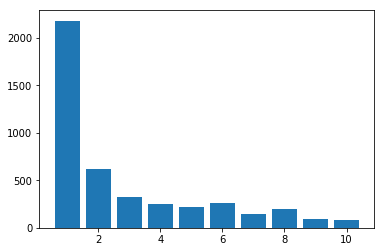

[2178  618  326  253  214  260  141  195   92   86]


In [35]:
values, counts = np.unique(labels, return_counts=True)
plt.bar(values, counts)
plt.show()
print(counts)

## 3. Methods and experiments

### 3.1 Preprocessing

With the range of feature vectors' values varying widely, a normalization of the feature vectors is a good way of improving the performance of ML algorithms. An common way of implementing the normalization is a min-max scaler or by using a sigmoid function. However, with our data with the feature values ranging from minimum of about -1700 and maximum of $10^6$, these functions would "squishify" the smaller end values too aggressively such that the many of the data points would become next to useless. That's why we ended up using sklearn's quantile transformer to normalize our data. The scaler transforms the features to a uniform distribution between zero and one spreading the most frequent values with also reducing the impact of outliers, which is also a good way of noise cancellation.

After the normalization, a set of additional features are added to each feature vector. The added features include the mean, minimum and maximum values as well as variance for each statistic of all the three different charcteristics (rhythm, chroma and MFCCs) in the feature space.


(*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 
*- What methods/algorithms, why were the methods chosen. *
*- What evaluation methodology (cross CV, etc.).*)



In [40]:
def scale_features(x):
    quantile_transformer = QuantileTransformer(random_state=0, n_quantiles=100, output_distribution="uniform")
    features= quantile_transformer.fit_transform(x)
    return features

def added_features(x):
    xi=[]
    for i in range(0,len(x)):
        feature_collector=[]
        #append all rythm statistics
        for j in range (0,168,24):
            rythm=np.median(x[i,j:j+24])
            mean_rythm=np.mean(x[i,j:j+24])
            var_rythm=np.var(x[i,j:j+24])
            min_rythm=np.min(x[i,j:j+24])
            max_rythm=np.max(x[i,j:j+24])
            feature_collector.append(rythm)
            feature_collector.append(var_rythm)
            feature_collector.append(mean_rythm)
            feature_collector.append(min_rythm)
            feature_collector.append(max_rythm)
            
        #append all chroma statistics
        for j in range(168,216,12):
            chroma=np.median(x[i,j:j+12])
            mean_chroma=np.mean(x[i,j:j+12])
            var_chroma=np.var(x[i,j:j+12])
            min_chroma=np.min(x[i,j:j+12])
            max_chroma=np.max(x[i,j:j+12])
            feature_collector.append(chroma)
            feature_collector.append(mean_chroma)
            feature_collector.append(var_chroma)
            feature_collector.append(min_chroma)
            feature_collector.append(max_chroma)
            
        #append mfcc
        feature_collector.append(np.median(x[i,216:246]))
        feature_collector.append(np.min(x[i,216:246]))
        feature_collector.append(np.max(x[i,216:246]))
        feature_collector.append(np.var(x[i,216:246]))
        
        xi.append(np.concatenate((feature_collector,x[i]),axis=None))
    return np.asarray(xi)

After normalizing and adding the features, the values are normalized between zero and one, and the dimesion of the feature matrix space $F$ has grown to $\mathbb{R}^{n \times 323}$.

In [51]:
features=scale_features(features)
features=added_features(features)
features,labels=sklearn.utils.shuffle(features,labels)
print(features.shape)

(4363, 323)


### 3.2 Classifier

In [45]:
clf=svm.SVC(kernel='rbf',C=12,gamma=0.0072, cache_size=5000, decision_function_shape="ovo")
y_p=cross_val_predict(clf,features, labels.ravel(), cv=5)

## 4. Results

Accuracy for the cross validation


(*Summarize the results of the experiments without discussing their implications.*
*- Include both performance measures (accuracy and LogLoss).*
*- How does it perform on kaggle compared to the train data.*
*- Include a confusion matrix.*)



In [46]:
accuracy=accuracy_score(labels,y_p)
print(accuracy)

0.6706394682557874


Log-loss

In [43]:
#A new classifier with the "probability" parametre True
clf=svm.SVC(kernel='rbf',C=12,gamma=0.0072, cache_size=5000, probability=True)

X_train, X_test, y_train, y_test = train_test_split(features, labels.ravel(), test_size=0.3)
clf.fit(X_train,y_train)
prob_test=clf.predict_proba(X_test)
print(log_loss(y_test, prob_test))

1.0990399373673057


## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

[1] MLBP 2018 Data Analysis Project - Problem Description

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *

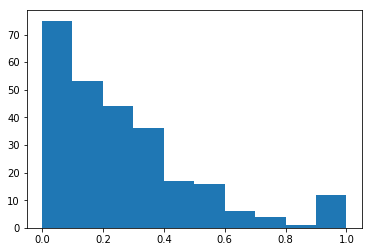

In [57]:
features=sklearn.preprocessing.minmax_scale(features,feature_range=(0,1))


plt.hist(features[2])
plt.show()